In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
zip_path = '/content/drive/MyDrive/Crime Prediction'

In [3]:
!unzip '/content/drive/MyDrive/Crime Prediction'

Streaming output truncated to the last 5000 lines.
  inflating: Train/Vandalism/Vandalism035_x264_230.png  
  inflating: Train/Vandalism/Vandalism035_x264_240.png  
  inflating: Train/Vandalism/Vandalism035_x264_250.png  
  inflating: Train/Vandalism/Vandalism035_x264_260.png  
  inflating: Train/Vandalism/Vandalism035_x264_270.png  
  inflating: Train/Vandalism/Vandalism035_x264_280.png  
  inflating: Train/Vandalism/Vandalism035_x264_290.png  
  inflating: Train/Vandalism/Vandalism035_x264_30.png  
  inflating: Train/Vandalism/Vandalism035_x264_300.png  
  inflating: Train/Vandalism/Vandalism035_x264_310.png  
  inflating: Train/Vandalism/Vandalism035_x264_320.png  
  inflating: Train/Vandalism/Vandalism035_x264_330.png  
  inflating: Train/Vandalism/Vandalism035_x264_340.png  
  inflating: Train/Vandalism/Vandalism035_x264_350.png  
  inflating: Train/Vandalism/Vandalism035_x264_360.png  
  inflating: Train/Vandalism/Vandalism035_x264_370.png  
  inflating: Train/Vandalism/Vandalism

In [4]:
train_dir = "/content/Train"
test_dir = "/content/Test"

In [5]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Rescaling
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Paths and constants
train_dir = "/content/Train"
test_dir = "/content/Test"
SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH)
BATCH_SIZE = 128
EPOCHS = 5
LR = 0.00003

In [7]:
# Classes and data counts
crime_types = os.listdir(train_dir)
n = len(crime_types)
print("Number of classes:", n)

Number of classes: 14


In [8]:
crimes={}
train=test=0
for clss in crime_types:
    num=len(os.listdir(os.path.join(train_dir,clss)))
    train+=num
    test+=len(os.listdir(os.path.join(test_dir,clss)))
    crimes[clss]=num

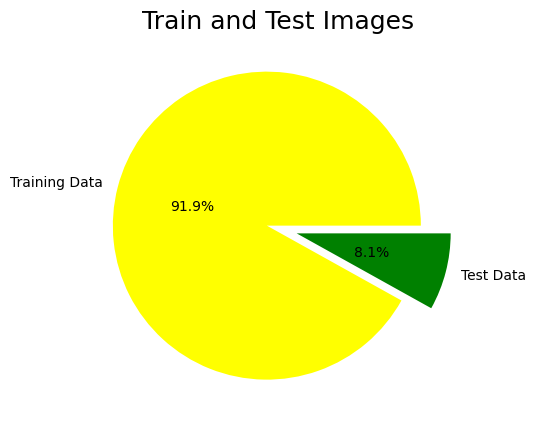

In [9]:
# Visualizations
plt.figure(figsize=(8, 5))
plt.pie(x=np.array([train, test]), autopct="%.1f%%", explode=[0.1, 0.1],
        labels=["Training Data", "Test Data"], pctdistance=0.5, colors=['yellow', 'green'])
plt.title("Train and Test Images ", fontsize=18)
plt.show()

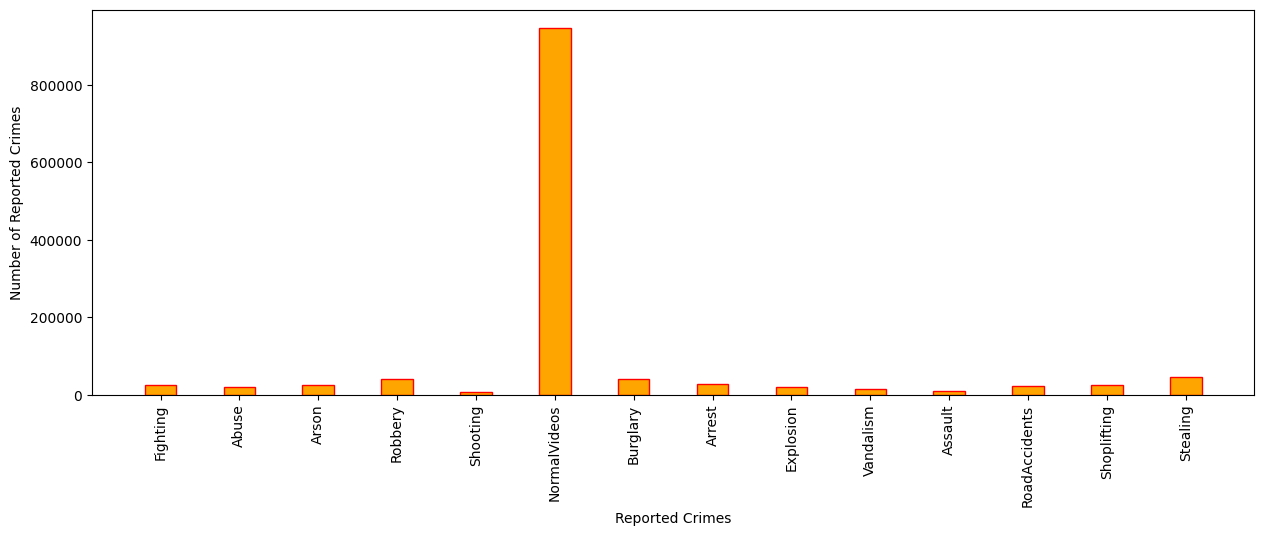

In [10]:
plt.figure(figsize=(15, 5))
plt.bar(list(crimes.keys()), list(crimes.values()), width=0.4, align="center",
        edgecolor=['red'], color=['orange'])
plt.xticks(rotation=90)
plt.xlabel("Reported Crimes")
plt.ylabel("Number of Reported Crimes")
plt.show()

In [11]:
# Datasets
train_set = image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="training",
)

Found 1266345 files belonging to 14 classes.
Using 1013076 files for training.


In [12]:
val_set = image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="validation",
)

Found 1266345 files belonging to 14 classes.
Using 253269 files for validation.


In [13]:
test_set = image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=False,
    seed=SEED,
)


Found 111308 files belonging to 14 classes.


In [14]:
def transfer_learning():
    base_model = DenseNet121(include_top=False, input_shape=(*IMG_SHAPE, 3), weights="imagenet")
    base_model.trainable = False  # Freeze all layers
    return base_model

In [15]:
def create_model():
    model = Sequential([
        Rescaling(1./255, input_shape=(*IMG_SHAPE, 3)),
        transfer_learning(),
        GlobalAveragePooling2D(),
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(512, activation="relu"),
        Dropout(0.2),
        Dense(1024, activation="relu"),
        Dense(n, activation="softmax")
    ])
    model.summary()
    return model

In [16]:
model = create_model()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 2, 2, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 14)             │        14,350 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,971,150 (30.41 MB)

 Trainable params: 933,646 (3.56 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [17]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow is using GPU:", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Num GPUs Available:  1
TensorFlow is using GPU: True


In [18]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [19]:
# Train the model
history = model.fit(x = train_set, validation_data = val_set,epochs = EPOCHS)

Epoch 1/5
7915/7915 ━━━━━━━━━━━━━━━━━━━━ 1274s 157ms/step - accuracy: 0.9216 - loss: 0.2883 - val_accuracy: 0.9881 - val_loss: 0.0441
Epoch 2/5
7915/7915 ━━━━━━━━━━━━━━━━━━━━ 1119s 138ms/step - accuracy: 0.9779 - loss: 0.0787 - val_accuracy: 0.9915 - val_loss: 0.0314
Epoch 3/5
7915/7915 ━━━━━━━━━━━━━━━━━━━━ 1110s 139ms/step - accuracy: 0.9824 - loss: 0.0638 - val_accuracy: 0.9930 - val_loss: 0.0253
Epoch 4/5
7915/7915 ━━━━━━━━━━━━━━━━━━━━ 1159s 139ms/step - accuracy: 0.9847 - loss: 0.0561 - val_accuracy: 0.9937 - val_loss: 0.0236
Epoch 5/5
7915/7915 ━━━━━━━━━━━━━━━━━━━━ 1139s 144ms/step - accuracy: 0.9862 - loss: 0.0523 - val_accuracy: 0.9938 - val_loss: 0.0229


In [20]:
# Save model
model.save('crime.h5')

In [21]:
from tensorflow.keras.models import load_model
model = load_model('crime.h5')

In [22]:
y_true = np.array([])

for x, y in test_set:
    y_true = np.concatenate([y_true, np.argmax(y.numpy(), axis=-1)])

In [23]:
y_pred = model.predict(test_set)

870/870 ━━━━━━━━━━━━━━━━━━━━ 59s 54ms/step


In [24]:
y_pred

array([[4.15910743e-02, 5.46100028e-02, 2.22563341e-01, ...,
        6.50838600e-04, 1.54452538e-02, 1.24139367e-02],
       [9.26568061e-02, 4.34445411e-01, 1.33306697e-01, ...,
        4.57693341e-06, 3.43285291e-03, 6.46322453e-03],
       [1.10941567e-03, 4.34351532e-04, 1.38249726e-03, ...,
        2.74705440e-06, 1.12909212e-04, 5.60294066e-05],
       ...,
       [1.98430644e-05, 7.75760873e-06, 2.74350004e-05, ...,
        1.00974512e-05, 1.51733148e-05, 1.21616168e-07],
       [2.01993157e-06, 1.49675998e-06, 4.15739095e-07, ...,
        1.12652776e-06, 3.71322272e-07, 4.87161707e-08],
       [5.12713427e-07, 1.34618830e-07, 1.80462028e-08, ...,
        1.10514776e-07, 1.86866860e-08, 9.54644630e-09]], dtype=float32)

In [25]:
y_true

array([ 0.,  0.,  0., ..., 13., 13., 13.])

In [26]:
y_pred = np.argmax(y_pred, axis=1)

In [27]:
from tensorflow.keras.preprocessing import image

img = image.load_img('/content/Test/RoadAccidents/RoadAccidents001_x264_0.png', target_size=(64,64))  # Reading image
x = image.img_to_array(img)  # Converting image into array
x = np.expand_dims(x, axis=0)  # Expanding Dimensions
pred = np.argmax(model.predict(x))  # Predicting the higher probability index

op = ['Fighting', 'Arrest', 'Vandalism', 'Assault', 'Stealing', 'Arson', 'NormalVideos', 'Burglary',
      'Explosion', 'Robbery', 'Abuse', 'Shooting', 'Shoplifting', 'RoadAccidents']

op[pred]  # List indexing with output

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


'Assault'

In [28]:
img = image.load_img('/content/Test/Shoplifting/Shoplifting001_x264_0.png', target_size=(64,64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
pred = np.argmax(model.predict(x))
op = ['Fighting', 'Arrest', 'Vandalism', 'Assault', 'Stealing', 'Arson', 'NormalVideos', 'Burglary',
      'Explosion', 'Robbery', 'Abuse', 'Shooting', 'Shoplifting', 'RoadAccidents']
op[pred]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


'Burglary'

In [29]:
img = image.load_img('/content/Test/Explosion/Explosion002_x264_0.png', target_size=(64,64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
pred = np.argmax(model.predict(x))
op = ['Fighting', 'Arrest', 'Vandalism', 'Assault', 'Stealing', 'Arson', 'NormalVideos', 'Burglary',
      'Explosion', 'Robbery', 'Abuse', 'Shooting', 'Shoplifting', 'RoadAccidents']
op[pred]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


'Burglary'

In [30]:
img = image.load_img('/content/Test/Burglary/Burglary005_x264_0.png', target_size=(64,64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
pred = np.argmax(model.predict(x))
op = ['Fighting', 'Arrest', 'Vandalism', 'Assault', 'Stealing', 'Arson', 'NormalVideos', 'Burglary',
      'Explosion', 'Robbery', 'Abuse', 'Shooting', 'Shoplifting', 'RoadAccidents']
op[pred]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


'RoadAccidents'

In [31]:
img = image.load_img('/content/Test/Robbery/Robbery048_x264_0.png', target_size=(64,64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
pred = np.argmax(model.predict(x))
op = ['Fighting', 'Arrest', 'Vandalism', 'Assault', 'Stealing', 'Arson', 'NormalVideos', 'Burglary',
      'Explosion', 'Robbery', 'Abuse', 'Shooting', 'Shoplifting', 'RoadAccidents']
op[pred]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


'Robbery'

In [32]:
import re
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from flask import Flask, app,request,render_template
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
from tensorflow.python.ops.gen_array_ops import concat
from tensorflow.keras.models import load_model


In [33]:
#Loading the model
model = load_model(r"crime.h5", compile=False)

app = Flask(__name__)

In [34]:
#home page
@app.route('/')
def home():
    return render_template('home.html')

#prediction page
@app.route('/prediction')
def prediction():
    return render_template('predict.html')

In [35]:
!pip install pyngrok

In [ ]:
import os
import numpy as np
from flask import Flask, request, render_template_string
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from werkzeug.utils import secure_filename
from pyngrok import ngrok

# Initialize Flask app
app = Flask(__name__)

# Load the trained model
model = load_model("crime.h5", compile=False)

# Define labels based on your training
labels = ['Fighting', 'Arrest', 'Vandalism', 'Assault', 'Stealing', 'Arson',
          'NormalVideos', 'Burglary', 'Explosion', 'Robbery', 'Abuse',
          'Shooting', 'Shoplifting', 'RoadAccidents']

# Configure upload folder
UPLOAD_FOLDER = 'uploads'
os.makedirs(UPLOAD_FOLDER, exist_ok=True)
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

# Home route
@app.route('/')
def home():
    return render_template_string("""
        <h2>Upload an Image to Predict Crime</h2>
        <form action="/predict" method="post" enctype="multipart/form-data">
            <input type="file" name="image" required>
            <input type="submit" value="Predict">
        </form>
    """)

# Prediction route
@app.route('/predict', methods=['POST'])
def predict():
    if request.method == 'POST':
        # Retrieve the uploaded file
        f = request.files['image']
        filename = secure_filename(f.filename)
        file_path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
        f.save(file_path)

        # Preprocess the image
        img = image.load_img(file_path, target_size=(64, 64))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)

        # Make prediction
        pred = np.argmax(model.predict(x), axis=1)[0]
        result = labels[pred]

        return f"<h3>Predicted Crime Category: <b>{result}</b></h3>"

# Run the app
if __name__ == "__main__":
    # Set up ngrok for public URL
    ngrok.set_auth_token("2yeEMU5DS4DJwLKV63mXeUzdwp3_4NxbciuXYywDJ2jquqybE")
    public_url = ngrok.connect(5000)
    print("Public URL:", public_url)
    app.run(port=5000)

Public URL: NgrokTunnel: "https://f43c24fbf607.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [09/Jul/2025 09:59:24] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/Jul/2025 09:59:25] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [09/Jul/2025 09:59:36] "GET / HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


INFO:werkzeug:127.0.0.1 - - [09/Jul/2025 09:59:53] "POST /predict HTTP/1.1" 200 -
